plot data in genome-wide

In [24]:
# python modules
import sys
import copy
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats

In [25]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [26]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [27]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}


In [28]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}


In [29]:
### chromosome choices
chr_choices = cell_chrnames['H1']
#chr_choices = ['chr1']

In [30]:
### load gtab file
gtab_path = "/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/"
dinfo_dkey = {'H1_NCP_sp_1rep_10kb_score.gtab.gz':
              {'H1_NCP_sp_8_1rep':(1, 'H1', 'score', 8)}}

chr_dkey_ID_value = load_file.read_gtab_batch (dinfo_dkey,
                                               data_path=gtab_path,
                                               chr_choices=chr_choices,
                                               by_chr_first=True)

loading H1_NCP_sp_1rep_10kb_score.gtab.gz


Done


In [31]:
### read G_banding file
gband_path = '/Users/sangwoopark/jhu_rockfish/HumanEpigeneticData/Gband/'
gband_fname = gband_path + 'Gband_human.txt'
chr_GID_Gband = load_file.read_Gband(gband_fname)

In [32]:
### read genome size
ref_path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/ref_files/'
ref_fname = ref_path + '4D_hg38.fa'
genome_size = load_file.read_genome_size(ref_fname,
                                         chr_choices=chr_choices)

In [55]:
### read RNA-seq data
RNAseq_path = '/Users/sangwoopark/jhu_rockfish/HumanEpigeneticData/RNAseq/'
RNAseq_fname = 'ENCFF174OMR.tsv'
#RNAseq_fname = 'ENCFF910OBU.tsv'
#RNAseq_fname = 'ENCFF395XDK.tsv'
#RNAseq_fname = 'ENCFF951EEA.tsv'
geneID_FPKM = load_file.read_ENCODE_RNA_seq(RNAseq_path + RNAseq_fname)

In [34]:
### read GTF file
GTF_path = '/Users/sangwoopark/jhu_rockfish/HumanEpigeneticData/GTF/'
GTF_fname = 'ENCFF159KBI.gtf'
geneID_field_value = load_file.read_GTF (GTF_path + GTF_fname,
                                         chr_list=chr_choices)

In [35]:
### figure parameters
# set figure binning parameters
i = 20
bin_size = int(0.5*(10**6) / i) # binsize (unit of bp)
bin_step = bin_size # no overlap
blur_win = int(4*i + 1) # sliding window (unit of bin)

In [36]:
### binning/smooting the condense-seq data
chr_dkey_sig = {}
for chr in chr_dkey_ID_value:
    for dkey in chr_dkey_ID_value[chr]:
        ID_value = chr_dkey_ID_value[chr][dkey]
        ID_loc = {ID:ID[1:] for ID in ID_value}
        max_pos = genome_size[chr]

        binID_mean = statis.rbin_data_mean(bin_size,
                                           bin_step,
                                           ID_loc,
                                           ID_value,
                                           max_pos=max_pos,
                                           silent=True)

        sig = [binID_mean[binID] for binID in sorted(binID_mean.keys())]
        sig = statis.slow_moving_average2(sig, blur_win)

        if chr not in chr_dkey_sig:
            chr_dkey_sig[chr] = {}
        chr_dkey_sig[chr][dkey] = sig


In [56]:
### rescale/reorganize the RNA-seq data
chr_geneID_pos = {}
chr_geneID_logFPKM = {}
min_FPKM = min(geneID_FPKM.values())
for geneID in geneID_FPKM:
    try:
        chr = geneID_field_value[geneID]['chr']
        pos = geneID_field_value[geneID]['TSS']
    except:
        continue

    if chr not in chr_geneID_pos:
        chr_geneID_pos[chr] = {}
    chr_geneID_pos[chr][geneID] = pos

    logFPKM = np.log2(geneID_FPKM[geneID] - min_FPKM + 1)
    if chr not in chr_geneID_logFPKM:
        chr_geneID_logFPKM[chr] = {}
    chr_geneID_logFPKM[chr][geneID] = logFPKM
    

In [57]:
### binning/smoothing the RNA-seq data
chr_RNA_sig = {}
for chr in chr_choices:
    geneID_pos = chr_geneID_pos[chr]
    geneID_logFPKM = chr_geneID_logFPKM[chr]
    max_pos = genome_size[chr]
    binID_mean = statis.rbin_data_mean(bin_size,
                                       bin_step,
                                       geneID_pos,
                                       geneID_logFPKM,
                                       max_pos=max_pos,
                                       silent=True)
    
    sig = [binID_mean[binID] for binID in sorted(binID_mean.keys())]
    sig = statis.slow_moving_average2(sig, blur_win)
    chr_RNA_sig[chr] = sig


In [39]:
### binning the G-banding data
chr_binID_GID = {}
chr_GID_binwin = {}
for chr in chr_choices:
    GID_Gband = chr_GID_Gband[chr]

    Int_dict_Gband = Interval_dict.bin_hash(bin_size,
                                            bin_step,
                                            genome_size[chr],
                                            silent=True)
    
    binID_GIDs = {}
    for GID in GID_Gband:
        st, ed = GID_Gband[GID]['interval']
        find_binIDs = Int_dict_Gband.insert_range(st, ed, 1)
        binID_value = Int_dict_Gband.get()
        for binID in find_binIDs:
            if binID not in binID_GIDs:
                binID_GIDs[binID] = []
            binID_GIDs[binID].append((binID_value[binID], GID))
        Int_dict_Gband.clear()

    binID_GID = {}
    GID_binIDs = {}
    for binID, GIDs in binID_GIDs.items():
        GID = sorted(GIDs, reverse=True)[0][1]
        binID_GID[binID] = GID
        if GID not in GID_binIDs:
            GID_binIDs[GID] = []
        GID_binIDs[GID].append(binID)

    GID_binwin = {}
    for GID, binIDs in GID_binIDs.items():
        GID_binwin[GID] = (min(binIDs), max(binIDs))
            
    chr_binID_GID[chr] = binID_GID
    chr_GID_binwin[chr] = GID_binwin

    del Int_dict_Gband, binID_GIDs, GID_binIDs


In [40]:
### make ideogram
chr_Gtype_ideogram = {}
for chr in chr_choices:
    GID_Gband = chr_GID_Gband[chr]
    Gtype_ideogram = {'num':[], 'var':[], 'acen':[]}
    binID_st, binID_ed = 0, genome_size[chr] / bin_step
    for binID in range(binID_st, binID_ed + 1):
        try:
            GID = chr_binID_GID[chr][binID]
            Gtype = GID_Gband[GID]['type']
            Gvalue = GID_Gband[GID]['value']
        except:
            for key in Gtype_ideogram:
                Gtype_ideogram[key].append([np.nan])
            continue

        if Gtype in ['neg', 'pos']:
            Gtype = 'num'
            assert not np.isnan(Gvalue)
        elif Gtype in ['var', 'acen']:
            Gvalue = 10
        else:
            pass
            
        for key in Gtype_ideogram:
            if key == Gtype:
                Gtype_ideogram[key].append([Gvalue])
            else:
                Gtype_ideogram[key].append([np.nan])

    chr_Gtype_ideogram[chr] = Gtype_ideogram

In [41]:
### set xtick labels along chromosome
chr_xtick_locs = {}
chr_xtick_labels = {}
for chr in chr_choices:
    xtick_locs, xtick_labels = [], []

    binID_st = 0
    binID_ed = genome_size[chr] / bin_step
    for binID in range(binID_st, binID_ed+1):
        pos = bin_step*binID + bin_size/2
        Mb_pos = int(round(float(pos)/(10**6)))

        if Mb_pos % 10 !=0: # 10Mbp steps
            continue

        label = str(Mb_pos)
        if label not in xtick_labels:
            xtick_locs.append(binID)
            xtick_labels.append(label)

    chr_xtick_locs[chr] = xtick_locs
    chr_xtick_labels[chr] = xtick_labels

In [42]:
### set xtick labels for ideogram
chr_Gtick_locs = {}
chr_Gtick_labels = {}
for chr in chr_GID_binwin:
    GID_binwin = chr_GID_binwin[chr]
    Gtick_locs, Gtick_labels = [], []
    for GID in sorted(GID_binwin.keys()):
        binID_st, binID_ed = GID_binwin[GID]
        pos = (binID_st + binID_ed)/2
        Gname = chr_GID_Gband[chr][GID]['name']
        Gtick_locs.append(pos)
        Gtick_labels.append(Gname)
    chr_Gtick_locs[chr] = Gtick_locs
    chr_Gtick_labels[chr] = Gtick_labels

In [43]:
### set heterochromatin regions of ideogram
chr_shade_wins = {}
for chr in chr_GID_binwin:
    GID_binwin = chr_GID_binwin[chr]
    shade_wins = []
    for GID in sorted(GID_binwin.keys()):
        Gtype = chr_GID_Gband[chr][GID]['type']
        if Gtype =='pos':
            shade_wins.append(GID_binwin[GID])
    chr_shade_wins[chr] = shade_wins


chr1


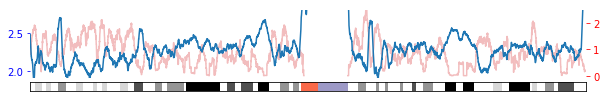


chr2


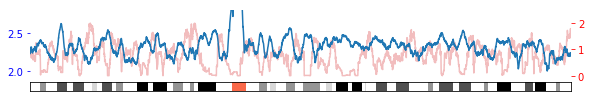


chr3


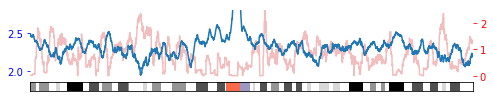


chr4


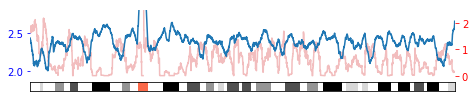


chr5


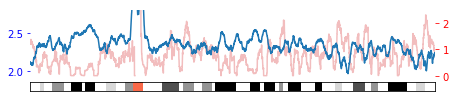


chr6


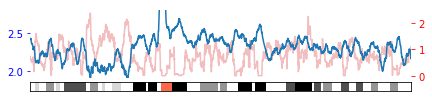


chr7


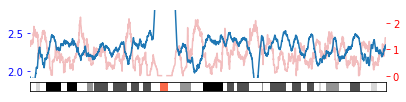


chr8


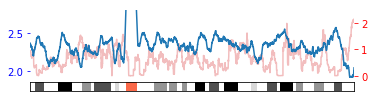


chr9


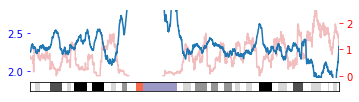


chr10


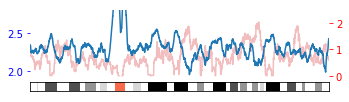


chr11


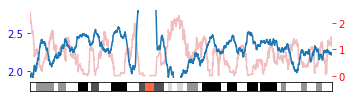


chr12


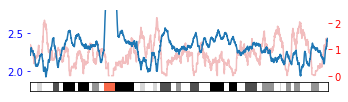


chr13


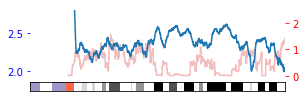


chr14


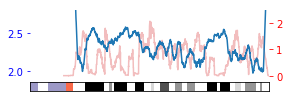


chr15


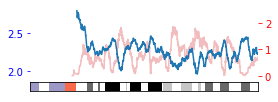


chr16


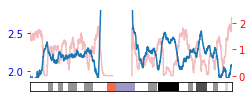


chr17


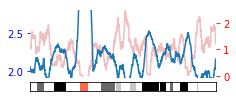


chr18


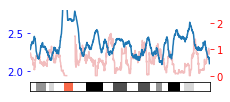


chr19


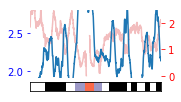


chr20


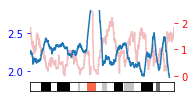


chr21


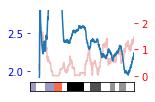


chr22


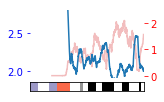


chrX


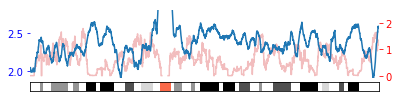


chrY


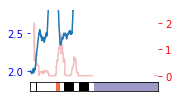

In [58]:
### plot genome-wide data along with ideogram
## figure parameters
side_names = {'left':[(1, 'H1', 'score', 8)],
              'right':['RNA']}
name_color = {(1, 'H1', 'score', 8):'tab:blue',
              'RNA':'tab:red'}
name_alpha = {(1, 'H1', 'score', 8):1,
              'RNA':0.3}
side_ylabel={'left':'',
             'right':''}
side_ycolor={'left':'blue',
             'right':'red'}
side_ylim={'left':[1.90, 2.80],
           'right':[-0.1, 2.5]}
spine_option={'top':False,
              'bottom':False,
              'left':False,
              'right':False}

#side_ylim={'left':None,
#           'right':None}
#side_yscale={'left':None,
#             'right':None}

## plot data in genome-wide (condensability vs gene expression)
for chr in chr_choices:
    print chr
    name_sig = chr_dkey_sig[chr]
    name_sig['RNA'] = chr_RNA_sig[chr]
    shade_wins = chr_shade_wins[chr]

    xaxis_len = len(name_sig['RNA'])

    fig_width = 0.001 * xaxis_len
    fig_height = 1.5
    
    graphics.plot_genome_wide(side_names=side_names,
                              name_sig=name_sig,
                              name_color=name_color,
                              name_alpha=name_alpha,
                              side_ylabel=side_ylabel,
                              side_ycolor=side_ycolor,
                              side_ylim=side_ylim,
                              xtick_locs=[],
                              xtick_labels=[],
                              Gtype_ideogram=chr_Gtype_ideogram[chr],
                              Gtick_locs=[],
                              Gtick_labels=[],
                              shade_wins=None,
                              xlabel='',
                              fig_width=fig_width,
                              fig_height=fig_height,
                              spine_option=spine_option,
                              height_ratios=[3, 0.4],
                              hspace=0.1,
                              save=False)
    print


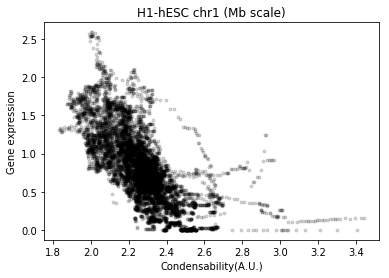

chr1
Spearman corr:-0.757286


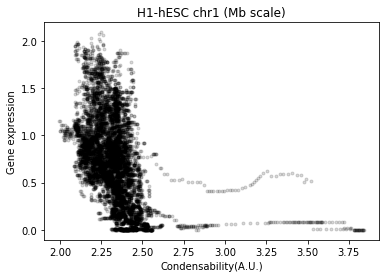

chr2
Spearman corr:-0.546373


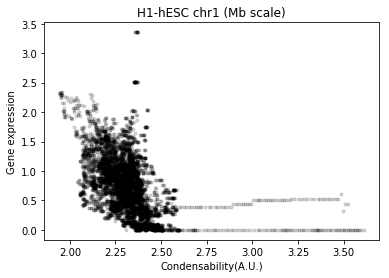

chr3
Spearman corr:-0.556549


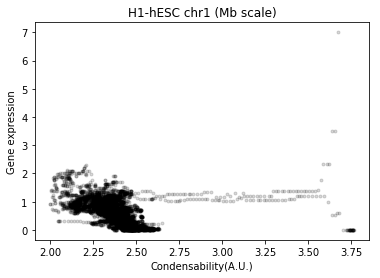

chr4
Spearman corr:-0.636432


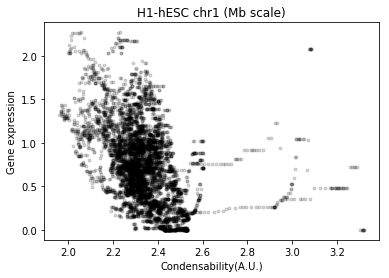

chr5
Spearman corr:-0.486933


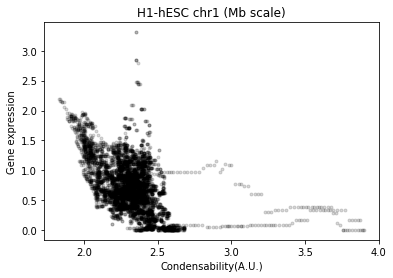

chr6
Spearman corr:-0.500207


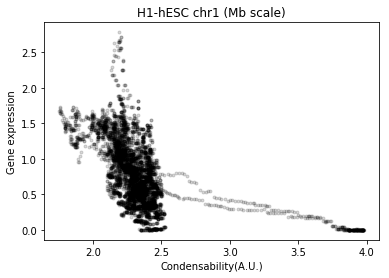

chr7
Spearman corr:-0.661490


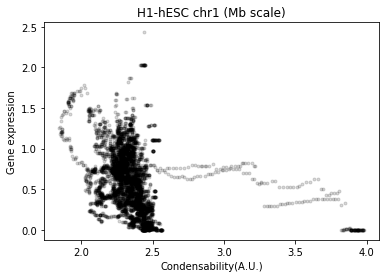

chr8
Spearman corr:-0.443891


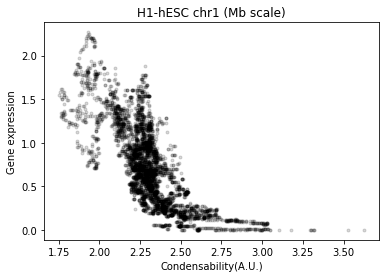

chr9
Spearman corr:-0.773515


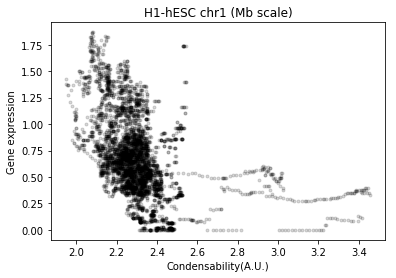

chr10
Spearman corr:-0.532190


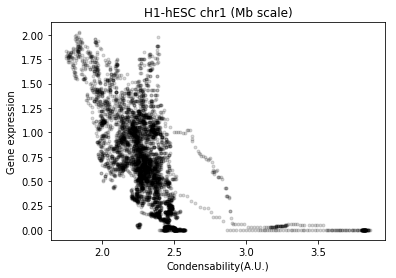

chr11
Spearman corr:-0.693402


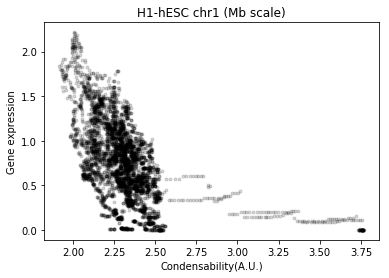

chr12
Spearman corr:-0.606982


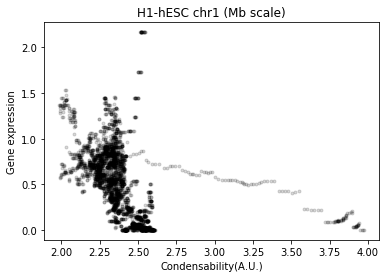

chr13
Spearman corr:-0.645999


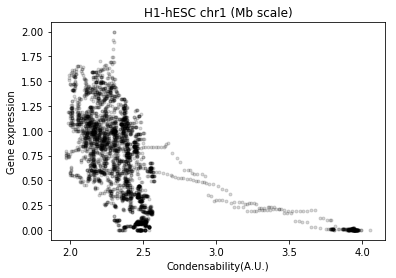

chr14
Spearman corr:-0.673211


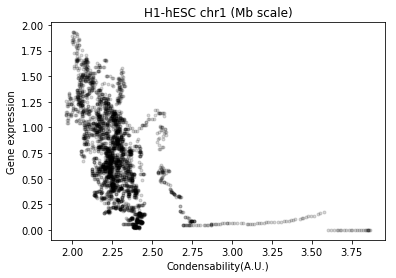

chr15
Spearman corr:-0.631132


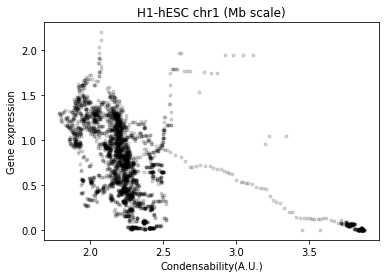

chr16
Spearman corr:-0.634267


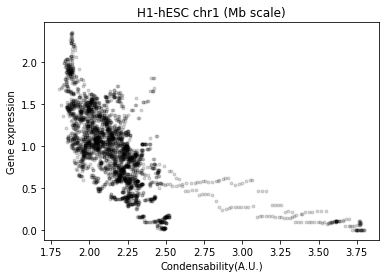

chr17
Spearman corr:-0.737161


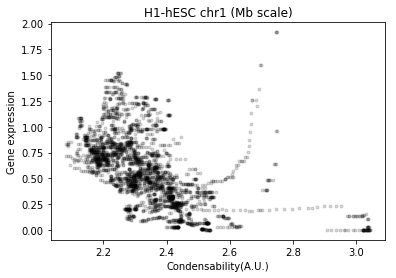

chr18
Spearman corr:-0.648165


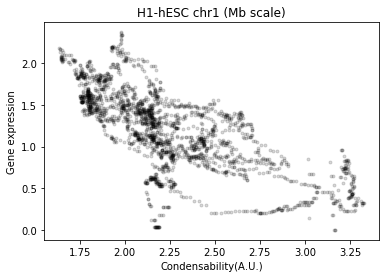

chr19
Spearman corr:-0.762159


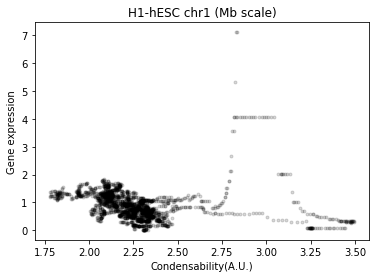

chr20
Spearman corr:-0.534129


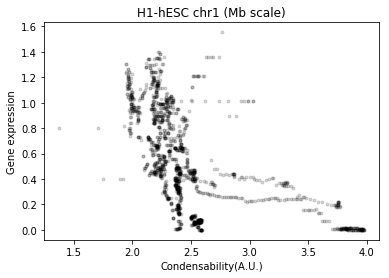

chr21
Spearman corr:-0.742887


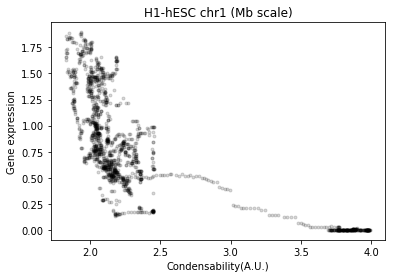

chr22
Spearman corr:-0.798622


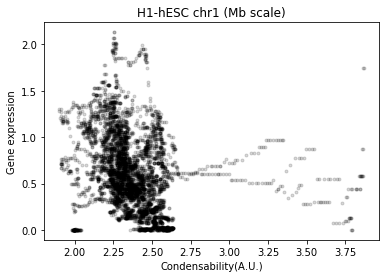

chrX
Spearman corr:-0.404338


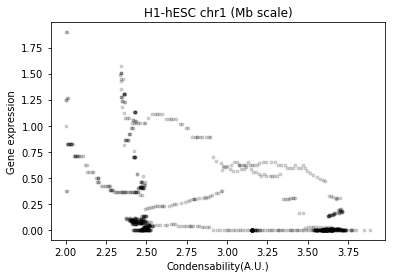

chrY
Spearman corr:-0.556158


In [45]:
### check the correation between signals (condensability VS gene expression)
for chr in chr_choices:
    X = chr_dkey_sig[chr][(1, 'H1', 'score', 8)]
    Y = chr_RNA_sig[chr]

    fig = plt.figure()
    plt.plot(X, Y, 'k.', alpha=0.15)
    plt.xlabel('Condensability(A.U.)')
    plt.ylabel('Gene expression')
    plt.title ('H1-hESC chr1 (Mb scale)')
    plt.show()

    corr = statis.get_spearman_corr(X, Y)

    print chr
    print 'Spearman corr:%f' % (corr)